# GLM HMM with EM on Simulated Data

In [105]:
# Import statements
import os
import traceback
import pickle
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from LearningSession import *
from LearningChoicePredictor import *
from LearningPsychometricPredictor import *
from SyntheticHMM import *
import pandas as pd
import seaborn as sns
import ssm

## Load Results

In [106]:
def plot_psychometric_clf(clf):
    data_prevl = []
    data_prevr = []
    for delta in range(-35,36):
        data_prevl.append([0,delta])
        data_prevr.append([1,delta])
    data_prevl = np.array(data_prevl)
    data_prevr = np.array(data_prevr)
    psychometric_curve_prevl = clf.predict_proba(data_prevl)
    psychometric_curve_prevr = clf.predict_proba(data_prevr)
    plt.plot(
        range(-35, 36),
        psychometric_curve_prevl[:,1], color="blue",
        label="Previous Choice Left"
        )
    plt.plot(
        range(-35, 36),
        psychometric_curve_prevr[:,1], color="red",
        label="Previous Choice Right"
        )
    plt.title("Probability of Choosing Right")
    plt.legend()
    plt.xlabel("More Left Beeps >>> More Right Beeps")
    plt.ylim((0,1))
    plt.axhline(0.5, color="gray")
    plt.axvline(0, color="gray")
    plt.show()

def plot_psychometric_coefs(coefs):
    clf = LogisticRegression()
    clf.coef_ = np.array([coefs[:-1]])
    clf.intercept_ = np.array([coefs[-1]])
    plot_psychometric_clf(clf)

In [148]:
filename = "std_prevbiased2state_results"
all_results = pickle.load(open(
    filename + ".p", "rb"
    ))
true_hmm = all_results['true_hmm']
results_K = all_results['results_K']
results_dsize = all_results['results_dsize']

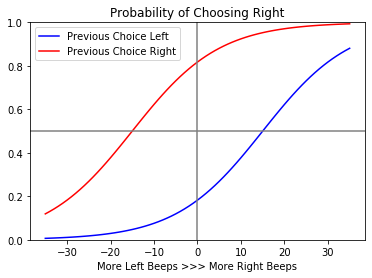

In [149]:
plot_psychometric_coefs(true_hmm.coefs[1])

## Test performance as a function of latent dimension

In [120]:
# Collect log likelihoods
test_lls = []
Ks = []
for K in results_K.keys():
    results = results_K[K][p_weight]
    for result in results:
        test_lls.append(result['test_ll'])
        Ks.append(K)
df = pd.DataFrame({
    'Ks': Ks, 'test_lls': test_lls
    })

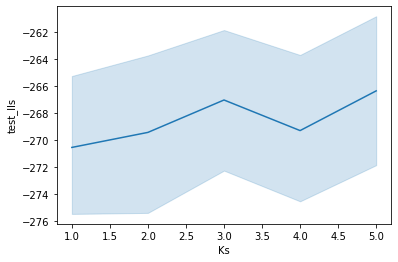

In [121]:
# Plot Log-Likes as a function of dimensions
sns.lineplot(
    x="Ks", y="test_lls", data=df
    )

## Test performance as a function of data size

In [122]:
# Collect log likelihoods
test_lls = []
dsizes = []
for dsize in results_dsize.keys():
    results = results_dsize[dsize][p_weight]
    for result in results:
        test_lls.append(result['test_ll'])
        dsizes.append(dsize)
df = pd.DataFrame({
    'dsizes': dsizes, 'test_lls': test_lls
    })

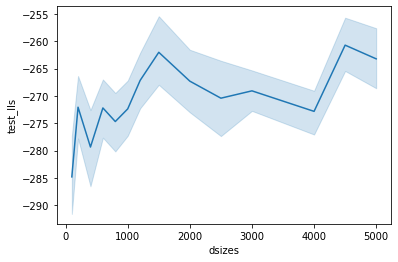

In [123]:
# Plot Log-Likes as a function of datasize
sns.lineplot(
    x="dsizes", y="test_lls", data=df
    )

## Comparing inferred psychometric curves

In [124]:
results_dsize.keys()

dict_keys([100, 200, 400, 600, 800, 1000, 1200, 1500, 2000, 2500, 3000, 4000, 4500, 5000])

In [133]:
results = results_dsize[1500][p_weight]
results_test_lls = [r['test_ll'] for r in results]
hmm = results[np.argmax(results_test_lls)]['hmm']

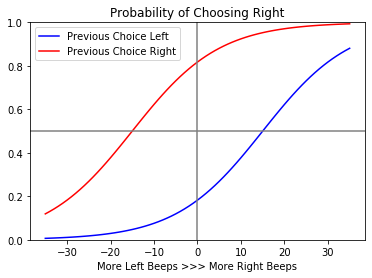

In [134]:
plot_psychometric_coefs(true_hmm.coefs[1])

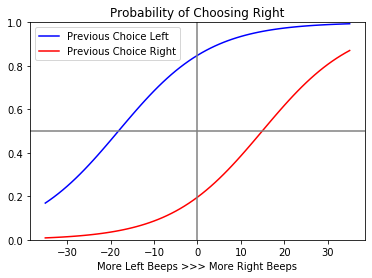

In [143]:
plot_psychometric_coefs(hmm.observations.coef[0])

In [138]:
hmm.observations.coef

array([[-3.13325552,  0.09475647,  1.7225435 ],
       [ 3.15296653,  0.10319512, -1.5819498 ]])

## Testing accuracy: predicted states and predicted choices

In [139]:
# Generate test data
test_size = 200
X_test = np.random.choice(
    np.arange(-30,31,1), size=test_size).reshape((-1,1))
sim_states_test, sim_y_test = true_hmm.sample(X_test)
sim_y_test = sim_y_test.astype(int)
sim_X_test = np.hstack((sim_y_test[:-1], X_test[1:].copy()))
sim_y_test = sim_y_test[1:]

In [140]:
predicted = hmm.most_likely_states(
    sim_y_test, input=sim_X_test
    )
expected = sim_states_test[1:]

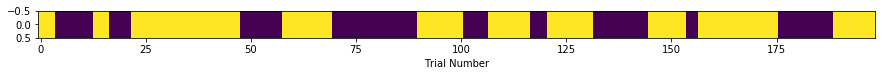

In [141]:
plt.figure(figsize=(15,0.5))
plt.imshow(
    predicted.reshape((1,-1)),
    aspect="auto")
plt.xlabel("Trial Number")
plt.show()

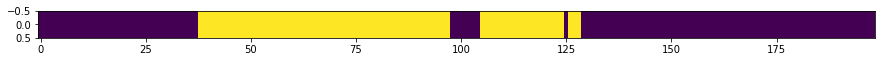

In [142]:
plt.figure(figsize=(15,0.5))
plt.imshow(
    expected.reshape((1,-1)),
    aspect="auto")
plt.show()

In [104]:
print("Proportion Identical")
print(np.sum(predicted == expected)/predicted.size)
print(np.sum(np.logical_not(predicted.astype(bool)) == expected.astype(bool))/predicted.size)

Proportion Identical
0.6532663316582915
0.34673366834170855
